## Sim Demo

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-10-18 13:52:40.323514: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-18 13:52:40.447290: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-18 13:52:40.584032: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-18 13:52:40.585158: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instruc

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run) 

<module 'sim.sim_run' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim_run.py'>

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 2.7%
RAM Usage: 5.5%
Available RAM: 951.9G
Total RAM: 1007.0G
52.4G


In [8]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 1
GPU 0: NVIDIA A100-SXM4-80GB - Memory Allocated: 0.00 GB


In [9]:
torch.cuda.is_available()

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

#### Simulation tests <a id="sims"></a>

In [44]:
from data.data_load import load_connectome, load_transcriptome, load_coords, load_network_labels

In [81]:
X_refgenome, valid_genes_refgenome = load_transcriptome(parcellation='S456', gene_list='0.2', sort_genes='refgenome',dataset='AHBA', omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', return_valid_genes=True, null_model='none', random_seed=42, run_PCA=None)
X = X_refgenome


Resorting genes by reference genome order


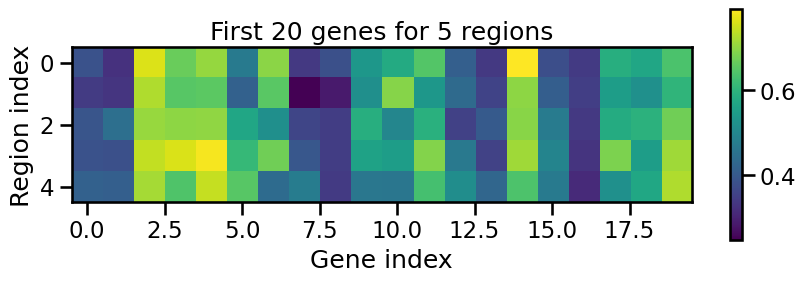

In [82]:
plt.figure(figsize=(10,3))
plt.imshow(X_refgenome[:5, 220:240], aspect='equal', cmap='viridis')
plt.colorbar()
plt.title('First 20 genes for 5 regions')
plt.xlabel('Gene index')
plt.ylabel('Region index') 
plt.show()


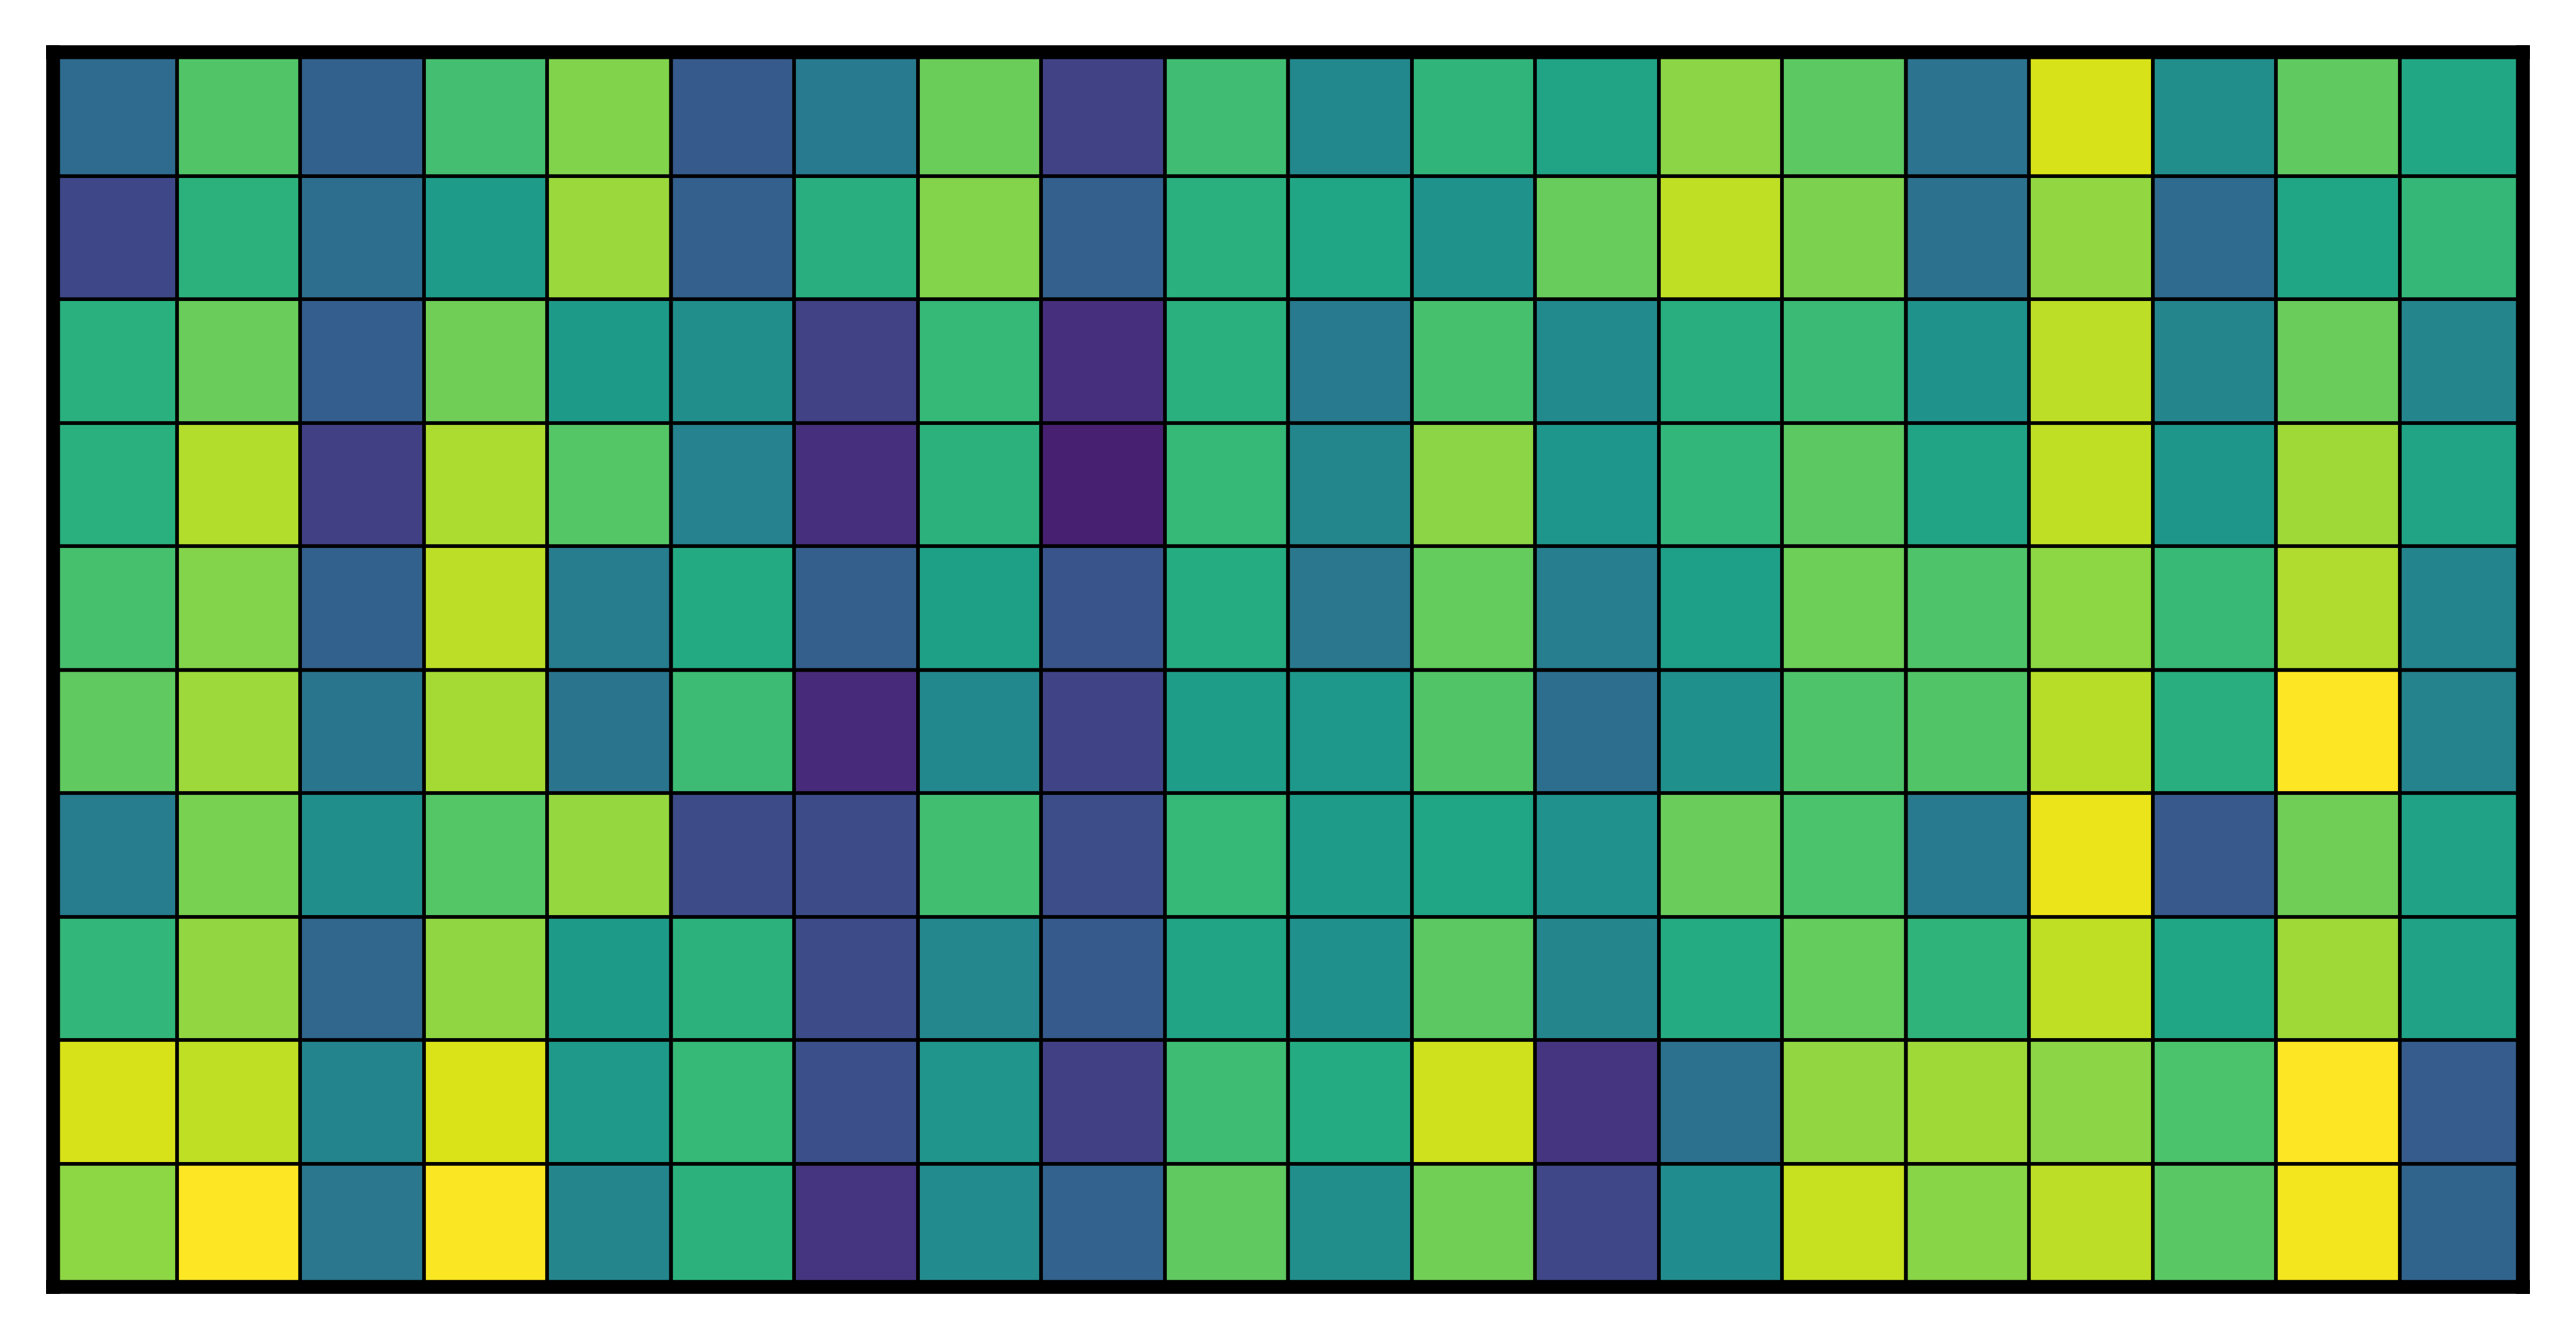

In [95]:
# Get first 10 regions, first 20 genes
data = X[:10, :20]

plt.figure(figsize=(6,15), dpi=600)  # Adjusted figure size for the larger data
ax = plt.gca()
ax.set_facecolor('none')  # Transparent background
plt.gcf().set_facecolor('none')  # Transparent figure background

# Plot the data
im = ax.imshow(data, aspect='equal', cmap='viridis', vmin=0.2, vmax=0.8, interpolation='nearest')

# Remove default grid
ax.grid(False)

# Add grid lines for each cell
for i in range(data.shape[0] + 1):
    ax.axhline(y=i-0.5, color='black', linewidth=0.5)
for i in range(data.shape[1] + 1):
    ax.axvline(x=i-0.5, color='black', linewidth=0.5)

# Add lines every 5 rows/columns (same width as other lines)
for i in range(0, data.shape[0] + 1, 5):
    ax.axhline(y=i-0.5, color='black', linewidth=0.5)
for i in range(0, data.shape[1] + 1, 5):
    ax.axvline(x=i-0.5, color='black', linewidth=0.5)

# Configure ticks
ax.set_xticks([])
ax.set_yticks([])

#plt.savefig('gene_expression_heatmap.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()


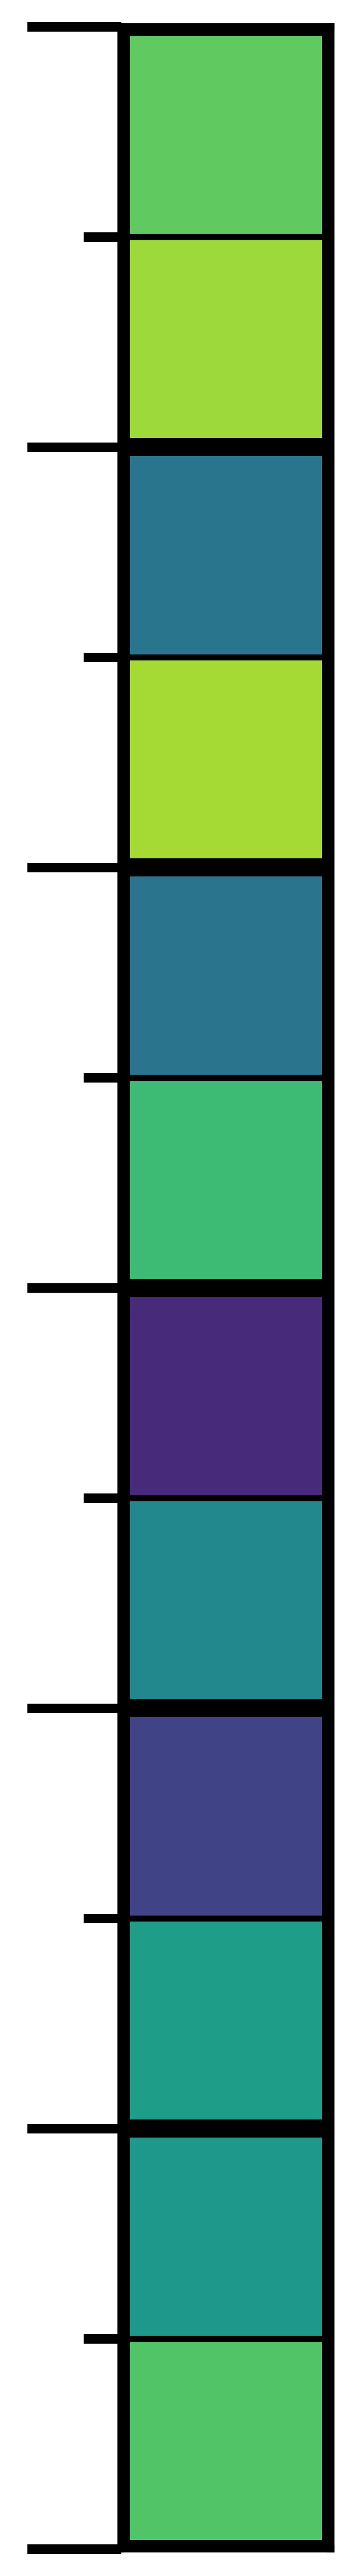

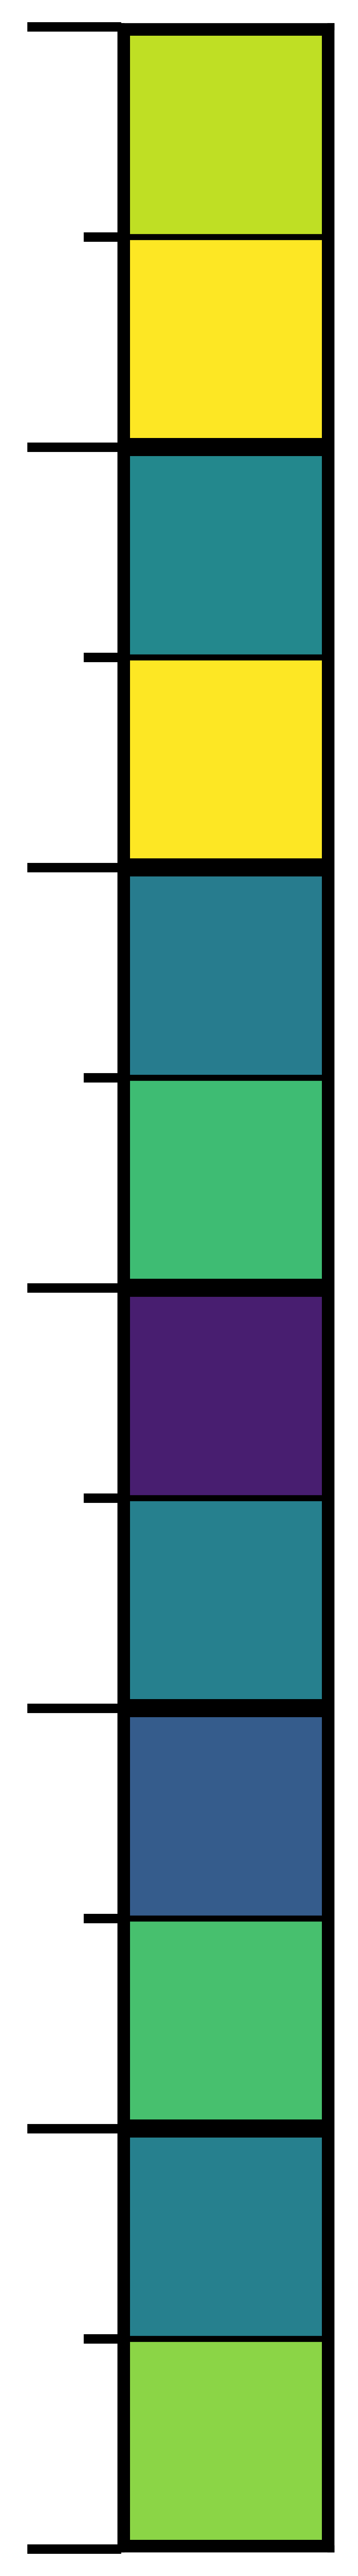

In [98]:
region6 = X[5, 0:12].reshape(-1,1)  
region11 = X[10, 0:12].reshape(-1,1)

plt.figure(figsize=(1,15), dpi=600)  # Increased DPI for higher resolution
ax1 = plt.gca()
ax1.set_facecolor('none')  # Transparent background
plt.gcf().set_facecolor('none')  # Transparent figure background
im1 = ax1.imshow(region6, aspect='equal', cmap='viridis', vmin=0.2, vmax=0.8, interpolation='nearest')

# Remove default grid
ax1.grid(False)
# Add grid lines exactly at pixel boundaries
for i in range(13):
    ax1.axhline(y=i-0.5, color='black', linewidth=1.6)
for i in range(2):
    ax1.axvline(x=i-0.5, color='black', linewidth=1.6)
# Add thicker lines every 2 squares
for i in range(0,13,2):
    ax1.axhline(y=i-0.5, color='black', linewidth=4.8)
ax1.axvline(x=-0.5, color='black', linewidth=4.8)
ax1.axvline(x=0.5, color='black', linewidth=4.8)
ax1.set_xticks([])
# Add ticks for each square and every 2nd square
ax1.set_yticks(np.arange(-0.5, 11.5, 1), minor=True)  # Individual squares
ax1.set_yticks([-0.5, 1.5, 3.5, 5.5, 7.5, 9.5, 11.5], minor=False)  # Block boundaries
ax1.set_yticklabels([])
ax1.tick_params(axis='y', which='minor', length=10, width=2.5)
ax1.tick_params(axis='y', which='major', length=25, width=2.5)
plt.savefig('region6.png', dpi=600, bbox_inches='tight', transparent=True)
#plt.show()

plt.figure(figsize=(1,15), dpi=600)  # Increased DPI for higher resolution
ax2 = plt.gca()
ax2.set_facecolor('none')  # Transparent background
plt.gcf().set_facecolor('none')  # Transparent figure background
im2 = ax2.imshow(region11, aspect='equal', cmap='viridis', vmin=0.2, vmax=0.8, interpolation='nearest')
# Remove default grid
ax2.grid(False)
# Add grid lines exactly at pixel boundaries
for i in range(13):
    ax2.axhline(y=i-0.5, color='black', linewidth=1.6)
for i in range(2):
    ax2.axvline(x=i-0.5, color='black', linewidth=1.6)
# Add thicker lines every 2 squares
for i in range(0,13,2):
    ax2.axhline(y=i-0.5, color='black', linewidth=4.8)
ax2.axvline(x=-0.5, color='black', linewidth=4.8)
ax2.axvline(x=0.5, color='black', linewidth=4.8)
ax2.set_xticks([])
# Add ticks for each square and every 2nd square
ax2.set_yticks(np.arange(-0.5, 11.5, 1), minor=True)  # Individual squares
ax2.set_yticks([-0.5, 1.5, 3.5, 5.5, 7.5, 9.5, 11.5], minor=False)  # Block boundaries
ax2.set_yticklabels([])
ax2.tick_params(axis='y', which='minor', length=10, width=2.5)
ax2.tick_params(axis='y', which='major', length=25, width=2.5)
plt.savefig('region11.png', dpi=600, bbox_inches='tight', transparent=True)
#plt.show()


In [86]:
X_random, valid_genes_random = load_transcriptome(parcellation='S456', gene_list='0.2', sort_genes='random',dataset='AHBA', omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', return_valid_genes=True, null_model='none', random_seed=42, run_PCA=None)
X = X_random


Randomly resorting genes


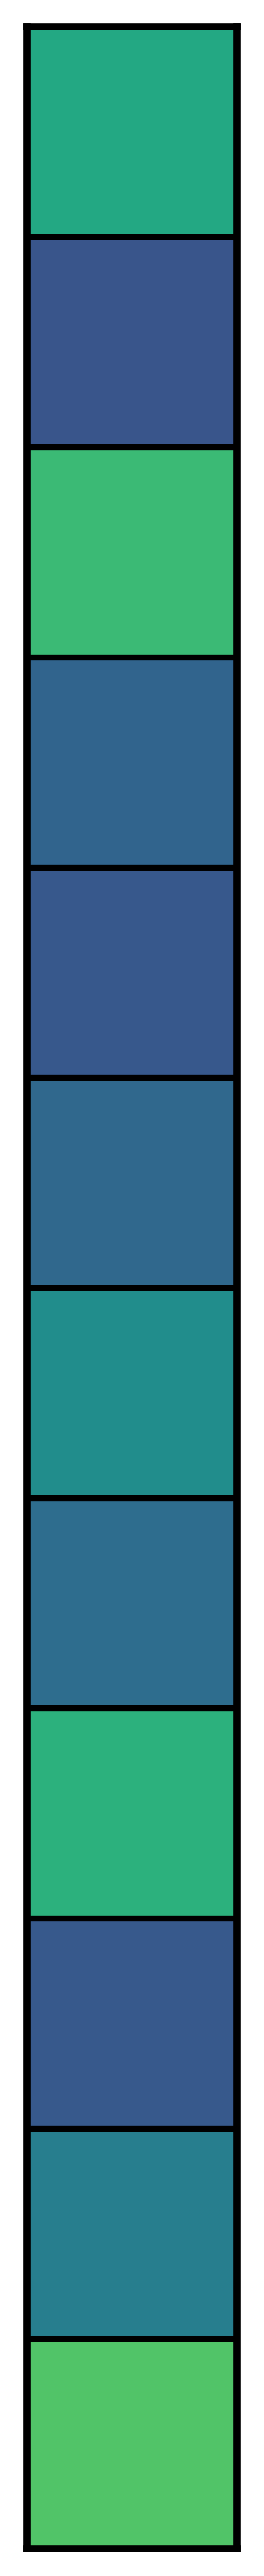

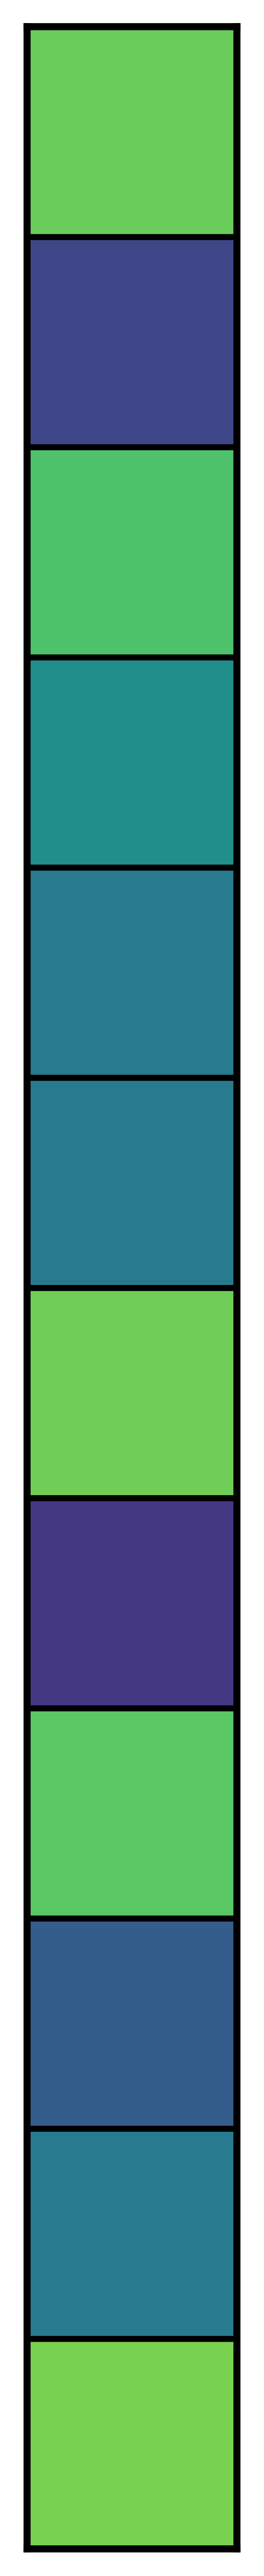

In [102]:
region6 = X[6, 20:32].reshape(-1,1)  
region11 = X[157, 20:32].reshape(-1,1)

plt.figure(figsize=(1,15), dpi=600)  # Increased DPI for higher resolution
ax1 = plt.gca()
ax1.set_facecolor('none')  # Transparent background
plt.gcf().set_facecolor('none')  # Transparent figure background
im1 = ax1.imshow(region6, aspect='equal', cmap='viridis', vmin=0.2, vmax=0.8, interpolation='nearest')

# Remove default grid
ax1.grid(False)
# Add grid lines exactly at pixel boundaries
for i in range(13):
    ax1.axhline(y=i-0.5, color='black', linewidth=1.6)
for i in range(2):
    ax1.axvline(x=i-0.5, color='black', linewidth=1.6)
ax1.set_xticks([])
ax1.set_yticks([])  # Remove all ticks
plt.savefig('region6.png', dpi=600, bbox_inches='tight', transparent=True)
#plt.show()

plt.figure(figsize=(1,15), dpi=600)  # Increased DPI for higher resolution
ax2 = plt.gca()
ax2.set_facecolor('none')  # Transparent background
plt.gcf().set_facecolor('none')  # Transparent figure background
im2 = ax2.imshow(region11, aspect='equal', cmap='viridis', vmin=0.2, vmax=0.8, interpolation='nearest')
# Remove default grid
ax2.grid(False)
# Add grid lines exactly at pixel boundaries
for i in range(13):
    ax2.axhline(y=i-0.5, color='black', linewidth=1.6)
for i in range(2):
    ax2.axvline(x=i-0.5, color='black', linewidth=1.6)
ax2.set_xticks([])
ax2.set_yticks([])  # Remove all ticks
plt.savefig('region11.png', dpi=600, bbox_inches='tight', transparent=True)
#plt.show()
